# PHYS 310 Project 

## Data Loading and Preamble

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from ase import Atoms
from ase.calculators.singlepoint import SinglePointCalculator
import os
from dscribe.descriptors import SOAP, ACSF
from dscribe.descriptors import ACSF
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from itertools import product
from tensorflow.keras.models import Sequential
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [ ]:
def parse_tio2_xsf(filename):
    """Parser optimized for this specific TiO2 XSF format."""
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    energy = None
    forces = []
    positions = []
    symbols = []
    lattice = []

    
    for i, line in enumerate(lines):
        if 'total energy =' in line:
            energy = float(line.split('=')[-1].strip().split()[0])
        elif line == 'PRIMVEC':
            lattice = [[float(x) for x in lines[i+1].split()],
                       [float(x) for x in lines[i+2].split()],
                       [float(x) for x in lines[i+3].split()]]
        elif line == 'PRIMCOORD':
            num_atoms = int(lines[i+1].split()[0])
            for j in range(i+2, i+2+num_atoms):
                parts = lines[j].split()
                symbols.append(parts[0])
                positions.append([float(x) for x in parts[1:4]])
                forces.append([float(x) for x in parts[4:7]])
            break

    # Create Atoms object first
    atoms = Atoms(
        symbols=symbols,
        positions=positions,
        cell=lattice,
        pbc=True
    )
    
    # Then attach calculator
    atoms.calc = SinglePointCalculator(
        atoms=atoms,
        energy=energy,
        forces=np.array(forces)
    )

    if energy is None:
        raise ValueError(f"No energy found in {filename}")
    
    # Add dimension validation
    if len(lattice) != 3 or any(len(vec)!=3 for vec in lattice):
        raise ValueError(f"Invalid lattice vectors in {filename}")
    
    return atoms

# Load data
structures = []
dataset_path = "data-set-2016-TiO2"
for filename in os.listdir(dataset_path):
    if filename.endswith(".xsf"):
        try:
            atoms = parse_tio2_xsf(os.path.join(dataset_path, filename))
            structures.append(atoms)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

# Create DataFrame
data = []

g2_params = [[0.005, 0.0], [0.05, 0.0], [0.5, 0.0], [1.0, 0.0]]
g4_params = [[0.005, 1.0, 1.0], [0.05, 1.0, 2.0], [0.5, 1.0, 4.0]]

acsf = ACSF(
    species=["Ti", "O"],
    r_cut=6.0,  
    g2_params = g2_params,
    g4_params = g4_params,
    periodic=True
)

for struct_id, atoms in enumerate(structures):
    try:
        energy = atoms.get_potential_energy()
        forces = atoms.get_forces()

        # Generate per-atom features
        sf_features = []
        for i in range(len(atoms)):
            # vec = acsf.create(atoms, centers=[i])[0]
            # sf_features.append(vec)
            vec = acsf.create(atoms, centers=[i])[0]
            if not np.all(np.isfinite(vec)):
                print(f"Structure {struct_id}, atom {i} has non-finite ACSF values!")
                raise ValueError("Descriptor contains inf or nan.")
            sf_features.append(vec)



        
        for atom_idx in range(len(atoms)):
            entry = {
                "struct_id": struct_id,
                "atom_type": atoms.symbols[atom_idx],
                "x": atoms.positions[atom_idx, 0],
                "y": atoms.positions[atom_idx, 1],
                "z": atoms.positions[atom_idx, 2],
                "fx": forces[atom_idx, 0],
                "fy": forces[atom_idx, 1],
                "fz": forces[atom_idx, 2],
                "total_energy": energy,
            }

            for f_idx, value in enumerate(sf_features[atom_idx]):
                entry[f"sf_{f_idx}"] = value

            data.append(entry)
    except Exception as e:
        print(f"Error processing structure {struct_id}: {str(e)}")
        continue

df = pd.DataFrame(data)
print(f"Successfully processed {len(structures)} structures")
print(f"DataFrame shape: {df.shape}")

Successfully processed 7815 structures
DataFrame shape: (165229, 28)


In [ ]:




data = []

g2_params = [[0.005, 0.0], [0.05, 0.0], [0.5, 0.0], [1.0, 0.0]]
g4_params = [[0.005, 1.0, 1.0], [0.05, 1.0, 2.0], [0.5, 1.0, 4.0]]

acsf = ACSF(
    species=["Ti", "O"],
    r_cut=6.0,  
    g2_params = g2_params,
    g4_params = g4_params,
    periodic=True
)

for struct_id, atoms in enumerate(structures):
    try:
        energy = atoms.get_potential_energy()
        forces = atoms.get_forces()

        # Generate per-atom features
        sf_features = []
        for i in range(len(atoms)):
            # vec = acsf.create(atoms, centers=[i])[0]
            # sf_features.append(vec)
            vec = acsf.create(atoms, centers=[i])[0]
            if not np.all(np.isfinite(vec)):
                print(f"Structure {struct_id}, atom {i} has non-finite ACSF values!")
                raise ValueError("Descriptor contains inf or nan.")
            sf_features.append(vec)



        
        for atom_idx in range(len(atoms)):
            entry = {
                "struct_id": struct_id,
                "atom_type": atoms.symbols[atom_idx],
                "x": atoms.positions[atom_idx, 0],
                "y": atoms.positions[atom_idx, 1],
                "z": atoms.positions[atom_idx, 2],
                "fx": forces[atom_idx, 0],
                "fy": forces[atom_idx, 1],
                "fz": forces[atom_idx, 2],
                "total_energy": energy,
            }

            for f_idx, value in enumerate(sf_features[atom_idx]):
                entry[f"sf_{f_idx}"] = value

            data.append(entry)
    except Exception as e:
        print(f"Error processing structure {struct_id}: {str(e)}")
        continue

df = pd.DataFrame(data)
print(f"Successfully processed {len(structures)} structures")
print(f"DataFrame shape: {df.shape}")

In [8]:
display(df)

,struct_id,atom_type,x,y,z,fx,fy,fz,total_energy,sf_0,...,sf_11,sf_12,sf_13,sf_14,sf_15,sf_16,sf_17,sf_18,n_atoms,per_atom_energy
0,0,Ti,4.420273,7.027096,2.241839,0.075930,-0.404276,0.694178,-19960.661733,11.117301,...,5.732577,0.001952,14.674119,5.657615,0.001360,1.434823,0.322629,5.693135e-08,24,-831.694239
1,0,Ti,4.457592,2.260299,2.239253,-0.056750,0.480562,0.891689,-19960.661733,11.139659,...,5.716655,0.002110,14.746504,5.688745,0.001428,1.448711,0.326712,5.884591e-08,24,-831.694239
2,0,Ti,1.447497,6.967589,2.373223,-0.094372,-0.580098,0.252683,-19960.661733,11.094012,...,5.623498,0.002012,14.768585,5.714726,0.001366,1.465127,0.334868,6.746745e-08,24,-831.694239
3,0,Ti,1.523171,2.357346,2.365012,0.090290,-0.332974,0.069115,-19960.661733,11.114758,...,5.665321,0.002206,14.871069,5.759558,0.001457,1.478706,0.338982,7.067922e-08,24,-831.694239
4,0,Ti,2.958649,4.671099,4.602973,1.464056,0.190740,-0.077073,-19960.661733,11.104883,...,5.704311,0.002099,14.646846,5.660316,0.001509,1.429292,0.323296,5.964305e-08,24,-831.694239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165224,7814,O,5.704683,2.852350,1.670885,-0.000051,-0.000074,0.024375,-39482.885537,8.946601,...,2.988279,0.000044,14.571886,6.600031,0.007095,2.244579,0.581080,7.385836e-06,47,-840.061394
165225,7814,O,0.022991,4.885306,6.468426,0.007542,0.002349,0.003897,-39482.885537,8.478271,...,2.586216,0.000038,13.634087,6.166955,0.006948,2.224970,0.582546,1.510168e-05,47,-840.061394
165226,7814,O,1.901525,6.655486,1.565511,-0.000035,-0.000015,-0.004176,-39482.885537,8.771699,...,2.896694,0.000048,14.432861,6.626200,0.007908,2.275023,0.611482,2.511071e-05,47,-840.061394
165227,7814,O,0.022946,0.819304,6.468436,0.007306,-0.002272,0.003950,-39482.885537,8.478281,...,2.586209,0.000038,13.634103,6.166920,0.006947,2.224988,0.582554,1.509915e-05,47,-840.061394


In [51]:
# Add these right after creating the DataFrame
# Calculate once at the start
df["n_atoms"] = df.groupby("struct_id")["atom_type"].transform("count")
df["per_atom_energy"] = df["total_energy"] / df["n_atoms"]

def get_top_features_per_species_xgb(df, species_list, top_n=10):
    """
    For each species, trains an XGBoost model to predict per-atom energy
    and extracts the top-N most important symmetry function features.
    """

    df = df.copy()
    df["n_atoms"] = df.groupby("struct_id")["atom_type"].transform("count")
    df["per_atom_energy"] = df["total_energy"] / df["n_atoms"]

    feature_cols = [col for col in df.columns if col.startswith("sf_")]
    species_top_features = {}
    importances_all = {}

    for species in species_list:
        print(f" Computing feature importances for species: {species}")
        sub_df = df[df["atom_type"] == species]
        X = sub_df[feature_cols].values
        y = sub_df["per_atom_energy"].values

        if len(X) < 50:
            print(f" Skipping {species}, too few atoms.")
            continue

        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
        model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train)

        # Get importances
        importances = model.get_booster().get_score(importance_type="gain")
        importances_df = pd.DataFrame({
            "feature": list(importances.keys()),
            "importance": list(importances.values())
        }).sort_values(by="importance", ascending=False)
        importances_df["feature"] = importances_df["feature"].apply(lambda f: f.replace("f", "sf_"))

        top_features = importances_df["feature"].head(top_n).tolist()
        species_top_features[species] = top_features
        importances_all[species] = importances_df

    return species_top_features, importances_all

species_top_features_full = get_top_features_per_species_xgb(df, species_list=["Ti", "O"], top_n=10)
species_top_features = species_top_features_full[0]
print(species_top_features['Ti'])
print(species_top_features['O'])


 Computing feature importances for species: Ti
 Computing feature importances for species: O
['sf_18', 'sf_0', 'sf_17', 'sf_5', 'sf_6', 'sf_16', 'sf_4', 'sf_11', 'sf_15', 'sf_1']
['sf_16', 'sf_0', 'sf_6', 'sf_8', 'sf_5', 'sf_7', 'sf_12', 'sf_13', 'sf_9', 'sf_17']


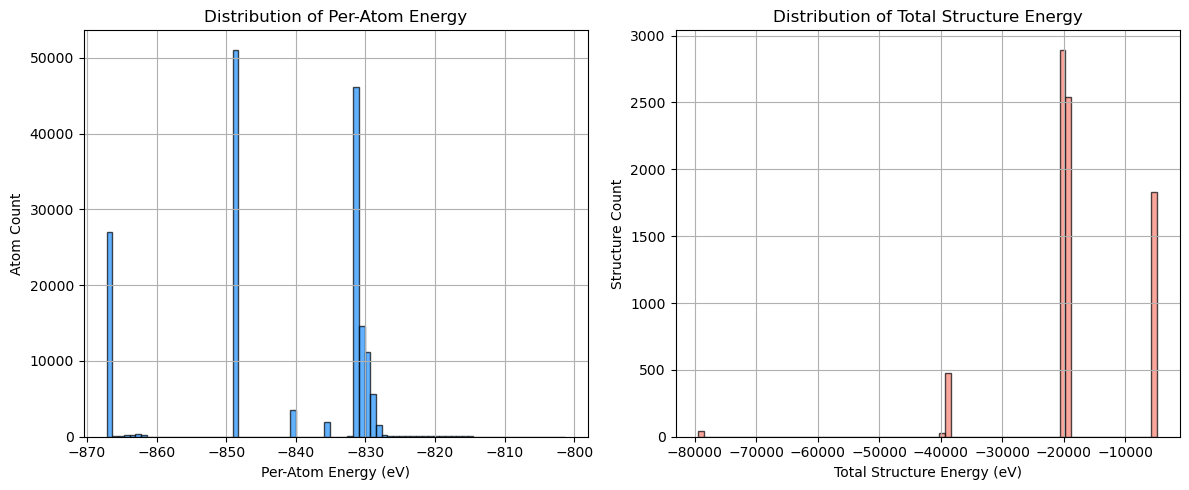

In [27]:

# === Histogram: Per-Atom Energy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df["per_atom_energy"], bins=80, alpha=0.7, color='dodgerblue', edgecolor='black')
plt.xlabel("Per-Atom Energy (eV)")
plt.ylabel("Atom Count")
plt.title("Distribution of Per-Atom Energy")
plt.grid(True)

# === Histogram: Structure Energy ===
structure_energies = df.groupby("struct_id")["total_energy"].first()

plt.subplot(1, 2, 2)
plt.hist(structure_energies, bins=80, alpha=0.7, color='salmon', edgecolor='black')
plt.xlabel("Total Structure Energy (eV)")
plt.ylabel("Structure Count")
plt.title("Distribution of Total Structure Energy")
plt.grid(True)

plt.tight_layout()
plt.savefig("energy_distributions.png", dpi=300)
plt.show()


## Regressors 

### Ridge Regressor


=== Optimizing Ridge for Ti ===
Best alpha: 0.0
RMSE: 5.6409 eV
MAE : 4.0736 eV
R²  : 0.8289

=== Optimizing Ridge for O ===
Best alpha: 0.0
RMSE: 6.1412 eV
MAE : 4.3002 eV
R²  : 0.7912

 Combined Per-Atom Evaluation:
MAE:  4.2224 eV/atom
RMSE: 5.9742 eV/atom
R²:   0.8045

 Per-Structure Evaluation:
MAE:  14252.4218 eV
RMSE: 16261.3990 eV


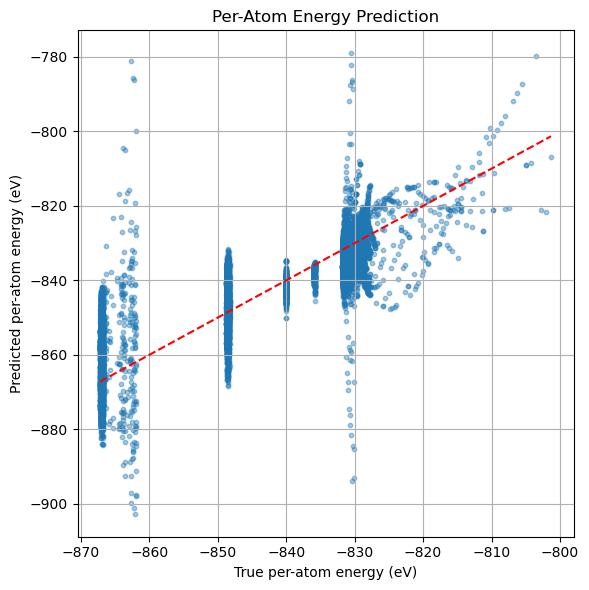

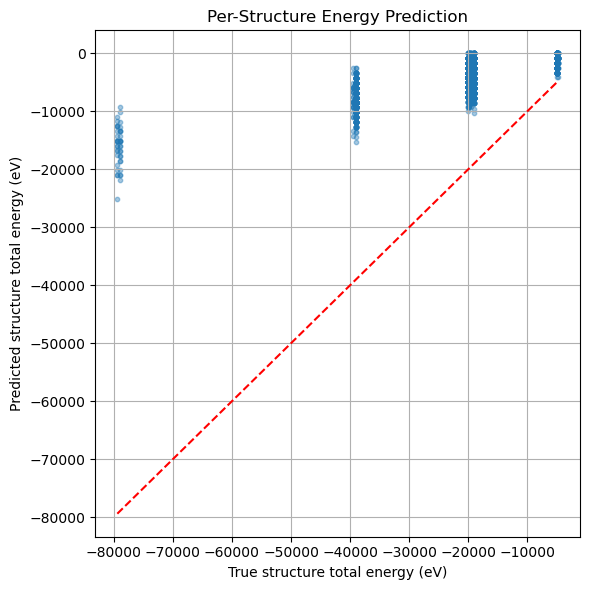

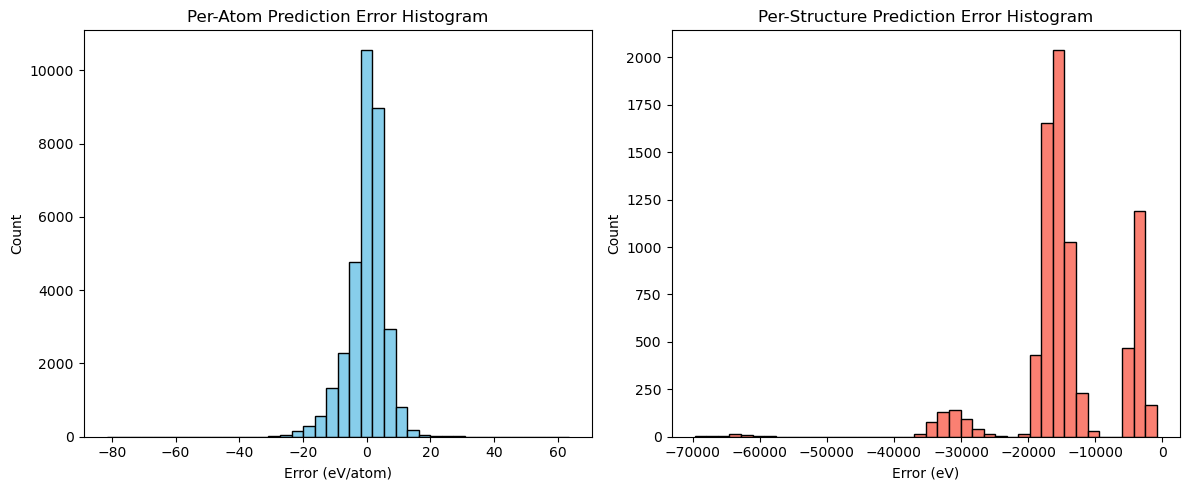

In [ ]:


# === Assume df and species_top_features are defined ===
df["n_atoms"] = df.groupby("struct_id")["atom_type"].transform("count")
df["per_atom_energy"] = df["total_energy"] / df["n_atoms"]

species_models = {}
scalers_X = {}
scalers_y = {}
results = {}

alpha_grid = [0.0, 1e-40, 1e-15, 1e-13, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]  # Feel free to adjust this

for species, features in species_top_features.items():
    print(f"\n=== Optimizing Ridge for {species} ===")
    sub_df = df[df["atom_type"] == species].copy()
    train_idx, test_idx = train_test_split(sub_df.index, test_size=0.2, random_state=42)
    X_train = sub_df.loc[train_idx, features].values
    y_train = sub_df.loc[train_idx, "per_atom_energy"].values
    X_test = sub_df.loc[test_idx, features].values
    y_test = sub_df.loc[test_idx, "per_atom_energy"].values

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1)).ravel()

    best_rmse = float("inf")
    best_model = None
    best_alpha = None
    best_pred = None

    for alpha in alpha_grid:
        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_alpha = alpha
            best_pred = y_pred

    print(f"Best alpha: {best_alpha}")
    print(f"RMSE: {best_rmse:.4f} eV")
    print(f"MAE : {mean_absolute_error(y_test, best_pred):.4f} eV")
    print(f"R²  : {r2_score(y_test, best_pred):.4f}")

    species_models[species] = best_model
    scalers_X[species] = scaler_X
    scalers_y[species] = scaler_y
    results[species] = {
        "y_true": y_test,
        "y_pred": best_pred,
        "test_mask": test_idx,
        "best_alpha": best_alpha
    }

# === Combine all predictions ===
all_y_true = []
all_y_pred = []
structure_energy_pred = defaultdict(float)
structure_energy_true = {}

for species in species_top_features:
    y_true = results[species]["y_true"]
    y_pred = results[species]["y_pred"]
    test_indices = results[species]["test_mask"]
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    for idx, pred in zip(test_indices, y_pred):
        sid = df.loc[idx, "struct_id"]
        structure_energy_pred[sid] += pred

for sid in df["struct_id"].unique():
    structure_energy_true[sid] = df[df["struct_id"] == sid]["total_energy"].iloc[0]

# === Final combined metrics ===
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
combined_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
combined_mae = mean_absolute_error(all_y_true, all_y_pred)
combined_r2 = r2_score(all_y_true, all_y_pred)

print("\n Combined Per-Atom Evaluation:")
print(f"MAE:  {combined_mae:.4f} eV/atom")
print(f"RMSE: {combined_rmse:.4f} eV/atom")
print(f"R²:   {combined_r2:.4f}")

# === Per-structure metrics ===
true_structures = np.array(list(structure_energy_true.values()))
pred_structures = np.array([structure_energy_pred[k] for k in structure_energy_true])
structure_mae = mean_absolute_error(true_structures, pred_structures)
structure_rmse = np.sqrt(mean_squared_error(true_structures, pred_structures))

print("\n Per-Structure Evaluation:")
print(f"MAE:  {structure_mae:.4f} eV")
print(f"RMSE: {structure_rmse:.4f} eV")

# === Plot true vs predicted per-atom ===
plt.figure(figsize=(6, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.4, s=10)
plt.plot([all_y_true.min(), all_y_true.max()], [all_y_true.min(), all_y_true.max()], 'r--')
plt.xlabel("True per-atom energy (eV)")
plt.ylabel("Predicted per-atom energy (eV)")
plt.title("Per-Atom Energy Prediction")
plt.grid(True)
plt.tight_layout()
plt.savefig("per_atom_energy_prediction_ridge.png", dpi=300)
plt.show()

# === Plot true vs predicted per-structure ===
plt.figure(figsize=(6, 6))
plt.scatter(true_structures, pred_structures, alpha=0.4, s=10)
plt.plot([true_structures.min(), true_structures.max()], [true_structures.min(), true_structures.max()], 'r--')
plt.xlabel("True structure total energy (eV)")
plt.ylabel("Predicted structure total energy (eV)")
plt.title("Per-Structure Energy Prediction")
plt.grid(True)
plt.tight_layout()
plt.savefig("per_structure_energy_prediction_ridge.png", dpi=300)
plt.show()

# === Histogram of prediction errors ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_y_true - all_y_pred, bins=40, color='skyblue', edgecolor='black')
plt.title("Per-Atom Prediction Error Histogram")
plt.xlabel("Error (eV/atom)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(true_structures - pred_structures, bins=40, color='salmon', edgecolor='black')
plt.title("Per-Structure Prediction Error Histogram")
plt.xlabel("Error (eV)")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("prediction_errors_ridge.png", dpi=300)
plt.show()


Changing alpha doesnt seem to have a significant effect on the results

### MLP Regressor

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Ti Best Params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}
Ti Test RMSE: 2.4013 eV
Fitting 3 folds for each of 48 candidates, totalling 144 fits
O Best Params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}
O Test RMSE: 2.9282 eV

📊 Total RMSE: 27.1920 eV


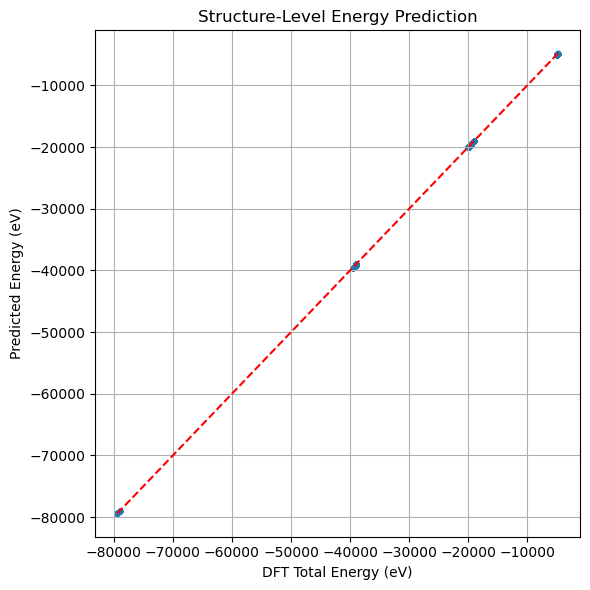

In [ ]:
species_names = list(species_top_features.keys())

df["n_atoms"] = df.groupby("struct_id")["atom_type"].transform("count")
df["per_atom_energy"] = df["total_energy"] / df["n_atoms"]

# === Per-Species Regressors ===
species_models = {}
scalers = {}

for species in species_names:
    mask = df["atom_type"] == species
    X = df.loc[mask, species_top_features[species]].values
    y = df.loc[mask, "per_atom_energy"].values

    # Normalize inputs
    scaler = StandardScaler().fit(X)
    scalers[species] = scaler
    X_scaled = scaler.transform(X)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Hyperparameter Grid
    # param_grid = {
    #     "hidden_layer_sizes": [(32,), (64,), (64, 32), (128, 64, 32)],
    #     "activation": ["relu", "tanh"],
    #     "alpha": [0.0001, 0.001, 0.01],
    #     "learning_rate_init": [0.001, 0.01]
    # }

    param_grid = {
        "hidden_layer_sizes": [(128, 64, 32)],
        "activation": ["tanh"],
        "alpha": [0.01],
        "learning_rate_init": [0.0008, 0.001, 0.0015]
    }

    model = MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)
    grid = GridSearchCV(model, param_grid, cv=3, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)

    species_models[species] = grid.best_estimator_
    print(f"{species} Best Params:", grid.best_params_)
    print(f"{species} Test RMSE: {np.sqrt(((grid.predict(X_test) - y_test) ** 2).mean()):.4f} eV")

# === Predict Structure Energies ===
structure_preds = defaultdict(list)
structure_true = {}

for i, row in df.iterrows():
    species = row["atom_type"]
    struct_id = row["struct_id"]

    if species in species_models:
        feats = row[species_top_features[species]].values.astype(float).reshape(1, -1)
        feats_scaled = scalers[species].transform(feats)
        energy = species_models[species].predict(feats_scaled)[0]
        structure_preds[struct_id].append(energy)

    if struct_id not in structure_true:
        structure_true[struct_id] = row["total_energy"]

predicted_energies = {k: sum(v) for k, v in structure_preds.items()}
true_energies = structure_true

# === Denormalize if needed (currently absolute energies)
y_true = np.array([true_energies[k] for k in predicted_energies])
y_pred = np.array([predicted_energies[k] for k in predicted_energies])

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f"\n Total RMSE: {rmse:.4f} eV")

# === Plotting ===
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("DFT Total Energy (eV)")
plt.ylabel("Predicted Energy (eV)")
plt.title("Structure-Level Energy Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()



 Training best MLP for Ti
Ti MAE : 1.7900 eV/atom
Ti RMSE: 3.2729 eV/atom
Ti R²   : 0.9431

 Training best MLP for O
O MAE : 2.5366 eV/atom
O RMSE: 4.2016 eV/atom
O R²   : 0.9030

 Per-Atom Combined Evaluation:
MAE : 2.2804 eV/atom
RMSE: 3.9078 eV/atom
R²  : 0.9171

 Per-Structure Evaluation:
MAE : 332.7539 eV
RMSE: 446.2731 eV
R²  : 0.9978


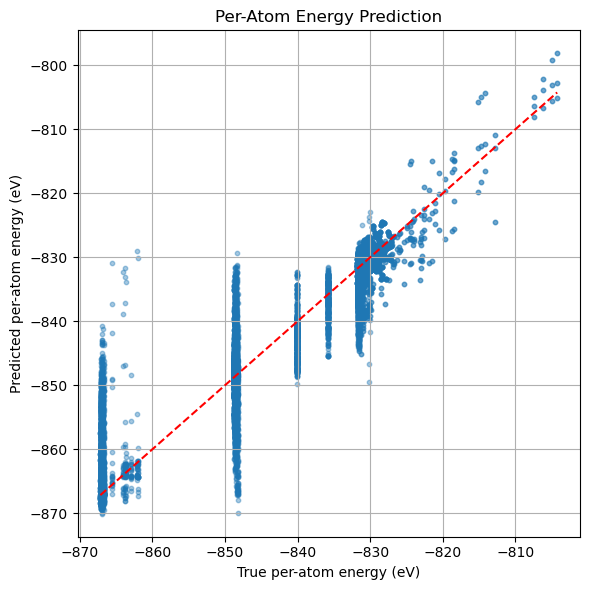

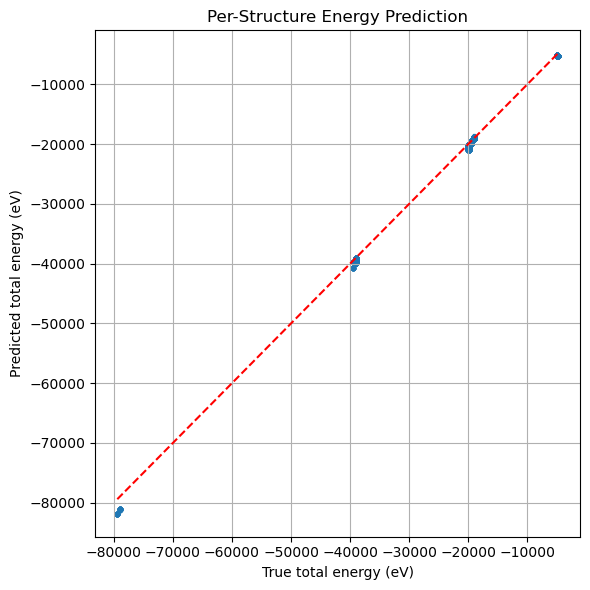

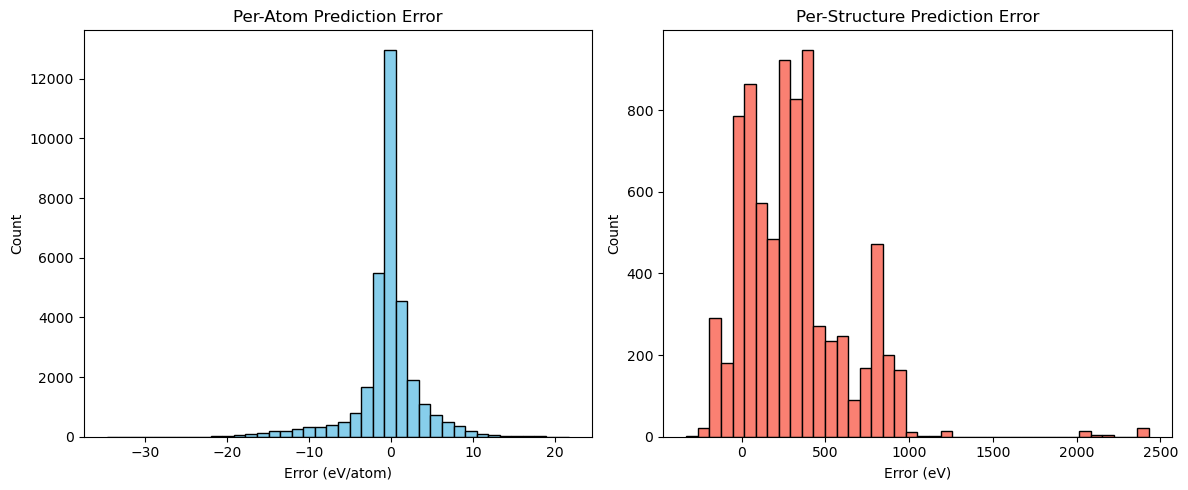

In [50]:


# === Setup ===
species_names = list(species_top_features.keys())

df["n_atoms"] = df.groupby("struct_id")["atom_type"].transform("count")
df["per_atom_energy"] = df["total_energy"] / df["n_atoms"]

species_models = {}
scalers = {}
per_atom_results = {}

# # === Train per-species MLP ===
# for species in species_names:
#     print(f"\n Training best MLP for {species}")
#     mask = df["atom_type"] == species
#     X = df.loc[mask, species_top_features[species]].values
#     y = df.loc[mask, "per_atom_energy"].values

#     scaler = StandardScaler().fit(X)
#     scalers[species] = scaler
#     X_scaled = scaler.transform(X)

#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Global Structure Split ===
all_structures = df['struct_id'].unique()
train_structs, test_structs = train_test_split(all_structures, test_size=0.2, random_state=42)

# === Train per-species models using GLOBAL splits ===
for species in species_names:
    print(f"\n Training best MLP for {species}")
    # Use global structure split for this species
    train_mask = (df['struct_id'].isin(train_structs)) & (df['atom_type'] == species)
    test_mask = (df['struct_id'].isin(test_structs)) & (df['atom_type'] == species)
    
    X_train = df.loc[train_mask, species_top_features[species]].values
    y_train = df.loc[train_mask, "per_atom_energy"].values
    X_test = df.loc[test_mask, species_top_features[species]].values
    y_test = df.loc[test_mask, "per_atom_energy"].values
    
    # Scale features (fit ONLY on training structures)
    scaler = StandardScaler().fit(X_train)  # Critical: fit only on train
    scalers[species] = scaler
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='tanh',
        alpha=0.01,
        learning_rate_init=0.001,
        max_iter=1000,
        early_stopping=True,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"{species} MAE : {mean_absolute_error(y_test, y_pred):.4f} eV/atom")
    print(f"{species} RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f} eV/atom")
    print(f"{species} R²   : {r2_score(y_test, y_pred):.4f}")

    species_models[species] = model
    per_atom_results[species] = {
        "y_true": y_test,
        "y_pred": y_pred
    }

# === Per-Atom Combined Evaluation ===
all_atom_true = np.concatenate([per_atom_results[s]["y_true"] for s in species_names])
all_atom_pred = np.concatenate([per_atom_results[s]["y_pred"] for s in species_names])

atom_mae = mean_absolute_error(all_atom_true, all_atom_pred)
atom_rmse = np.sqrt(mean_squared_error(all_atom_true, all_atom_pred))
atom_r2 = r2_score(all_atom_true, all_atom_pred)

print("\n Per-Atom Combined Evaluation:")
print(f"MAE : {atom_mae:.4f} eV/atom")
print(f"RMSE: {atom_rmse:.4f} eV/atom")
print(f"R²  : {atom_r2:.4f}")

# === Predict per-structure total energies ===
structure_preds = defaultdict(list)
structure_true = {}

for i, row in df.iterrows():
    species = row["atom_type"]
    struct_id = row["struct_id"]
    if species not in species_models:
        continue
    features = row[species_top_features[species]].values.reshape(1, -1)
    features_scaled = scalers[species].transform(features)
    energy = species_models[species].predict(features_scaled)[0]
    structure_preds[struct_id].append(energy)
    if struct_id not in structure_true:
        structure_true[struct_id] = row["total_energy"]

# === Per-Structure Evaluation ===
y_true_struct = np.array([structure_true[k] for k in structure_preds])
y_pred_struct = np.array([sum(v) for v in structure_preds.values()])

struct_mae = mean_absolute_error(y_true_struct, y_pred_struct)
struct_rmse = np.sqrt(mean_squared_error(y_true_struct, y_pred_struct))
struct_r2 = r2_score(y_true_struct, y_pred_struct)

print("\n Per-Structure Evaluation:")
print(f"MAE : {struct_mae:.4f} eV")
print(f"RMSE: {struct_rmse:.4f} eV")
print(f"R²  : {struct_r2:.4f}")

# === PLOTS ===

# Per-Atom True vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(all_atom_true, all_atom_pred, alpha=0.4, s=10)
plt.plot([all_atom_true.min(), all_atom_true.max()], [all_atom_true.min(), all_atom_true.max()], 'r--')
plt.xlabel("True per-atom energy (eV)")
plt.ylabel("Predicted per-atom energy (eV)")
plt.title("Per-Atom Energy Prediction")
plt.grid(True)
plt.tight_layout()
plt.savefig("per_atom_energy_prediction_mlp.png", dpi=300)
plt.show()

# Per-Structure True vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_true_struct, y_pred_struct, alpha=0.4, s=10)
plt.plot([y_true_struct.min(), y_true_struct.max()], [y_true_struct.min(), y_true_struct.max()], 'r--')
plt.xlabel("True total energy (eV)")
plt.ylabel("Predicted total energy (eV)")
plt.title("Per-Structure Energy Prediction")
plt.grid(True)
plt.tight_layout()
plt.savefig("per_structure_energy_prediction_mlp.png", dpi=300)
plt.show()

# Error Histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_atom_true - all_atom_pred, bins=40, color='skyblue', edgecolor='black')
plt.title("Per-Atom Prediction Error")
plt.xlabel("Error (eV/atom)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(y_true_struct - y_pred_struct, bins=40, color='salmon', edgecolor='black')
plt.title("Per-Structure Prediction Error")
plt.xlabel("Error (eV)")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("prediction_errors_mlp.png", dpi=300)
plt.show()


## Neural Network

### Grid Search


🔍 Grid search for Ti
  🔧 Trying config: {'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 0.001, 'dropout_rate': 0.0, 'l2_strength': 0.0, 'epochs': 50, 'batch_size': 32}
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  🔧 Trying config: {'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 0.001, 'dropout_rate': 0.05, 'l2_strength': 0.0, 'epochs': 50, 'batch_size': 32}
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  🔧 Trying config: {'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 0.0005, 'dropout_rate': 0.0, 'l2_strength': 0.0, 'epochs': 50, 'batch_size': 32}
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  🔧 Trying config: {'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 0.0005, 'dropout_rate': 0.05, 'l2_strength': 0.0, 'epochs': 50, 'batch_size': 32}
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  🔧 Trying config: {'hidden_layer_sizes': (256, 128, 64), 'learning_rate': 0.001, 'dropout_rate': 0.0, 'l2_strength': 0.0, 'epochs': 50, 'batch_size': 32}
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

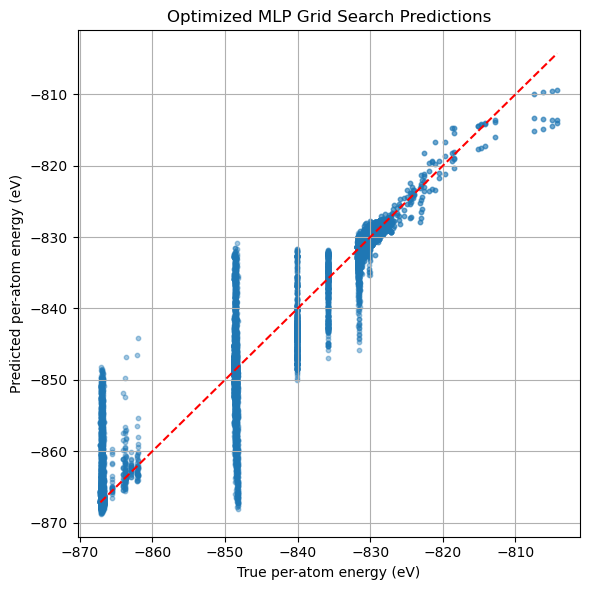

In [ ]:
#Parameter grid was modified for future running which didnt happen, originally it varied more parameters
# === Define hyperparameter grid ===
param_grid = {
    "hidden_layer_sizes": [(256, 128, 64)],
    "learning_rate": [0.0004, 0.0005, 0.0006, 0.0007],
    "dropout_rate": [0.05],
    "l2_strength": [0.0],
    "epochs": [50],
    "batch_size": [32]
}
grid_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

def build_model(input_dim, config):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for size in config["hidden_layer_sizes"]:
        model.add(Dense(size, activation="tanh", kernel_regularizer=l2(config["l2_strength"])))
        model.add(BatchNormalization())
        model.add(Dropout(config["dropout_rate"]))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=config["learning_rate"]), loss="mse")
    return model

def run_grid_search(species, feature_list):
    print(f"\n Grid search for {species}")
    struct_ids = df[df["atom_type"] == species]["struct_id"].unique()
    train_structs, test_structs = train_test_split(struct_ids, test_size=0.2, random_state=42)
    train_mask = df["struct_id"].isin(train_structs) & (df["atom_type"] == species)
    test_mask = df["struct_id"].isin(test_structs) & (df["atom_type"] == species)

    X_train = df.loc[train_mask, feature_list].values
    y_train = df.loc[train_mask, "per_atom_energy"].values
    X_test = df.loc[test_mask, feature_list].values
    y_test = df.loc[test_mask, "per_atom_energy"].values

    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))
    X_train_scaled = x_scaler.transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

    best_mae = float('inf')
    best_model = None
    best_params = None

    for combo in grid_combinations:
        config = dict(zip(param_names, combo))
        print(f"  - Trying config: {config}")
        model = build_model(X_train.shape[1], config)
        history = model.fit(
            X_train_scaled, y_train_scaled,
            validation_split=0.1,
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
            ]
        )
        y_pred_scaled = model.predict(X_test_scaled).ravel()
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        mae = mean_absolute_error(y_test, y_pred)

        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_params = config

    print(f"Best config for {species}: {best_params} (MAE: {best_mae:.4f} eV/atom)")
    return best_model, best_params, x_scaler, y_scaler, X_test, y_test

# === Run grid search and evaluate ===
results = {}
for species, features in species_top_features.items():
    model, params, x_scaler, y_scaler, X_test, y_test = run_grid_search(species, features)
    y_pred = y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test)).reshape(-1, 1)).ravel()
    results[species] = {
        "y_test": y_test,
        "y_pred": y_pred,
        "best_params": params}


# === Combined evaluation ===
all_true = np.concatenate([results[s]["y_test"] for s in results])
all_pred = np.concatenate([results[s]["y_pred"] for s in results])

print("\n Final Evaluation:")
for s in results:
    print(f"{s} MAE: {mean_absolute_error(results[s]['y_test'], results[s]['y_pred']):.4f} eV/atom")
    print(f"   Best config: {results[s]['best_params']}")
combined_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
print(f"Combined MAE: {mean_absolute_error(all_true, all_pred):.4f}")
print(f"Combined RMSE: {combined_rmse:.4f} eV/atom")
print(f"Combined R² : {r2_score(all_true, all_pred):.4f}")


# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(all_true, all_pred, alpha=0.4, s=10)
plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--')
plt.xlabel("True per-atom energy (eV)")
plt.ylabel("Predicted per-atom energy (eV)")
plt.title("Optimized MLP Grid Search Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()


### Singular


=== Training Ti Model ===
Epoch 1/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 2.0856 - mae: 0.5510 - val_loss: 0.1604 - val_mae: 0.3062 - learning_rate: 0.0093
Epoch 2/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1102 - mae: 0.2259 - val_loss: 0.1181 - val_mae: 0.2548 - learning_rate: 0.0093
Epoch 3/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1003 - mae: 0.2134 - val_loss: 0.1069 - val_mae: 0.2066 - learning_rate: 0.0093
Epoch 4/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0903 - mae: 0.2005 - val_loss: 0.4119 - val_mae: 0.5187 - learning_rate: 0.0093
Epoch 5/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0849 - mae: 0.1928 - val_loss: 0.1188 - val_mae: 0.2386 - learning_rate: 0.0093
Epoch 6/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0853 - mae: 0.1947 - val_loss: 0.2450 - val_mae: 0.3587 - learning_rate: 0.0093
Epoch 7/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0884 - mae: 0.2011 - val_loss: 0.1158 - val_mae: 0.2

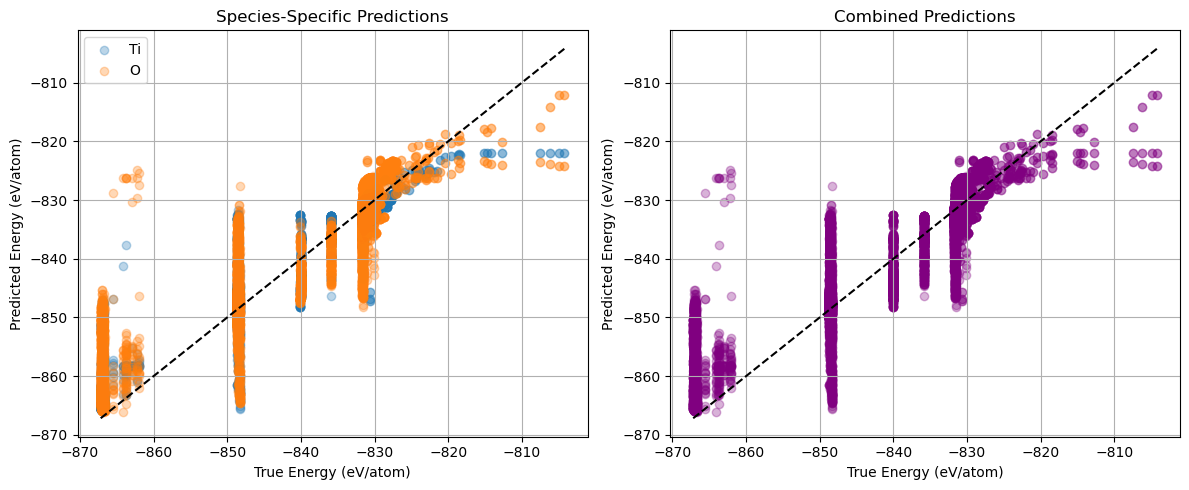

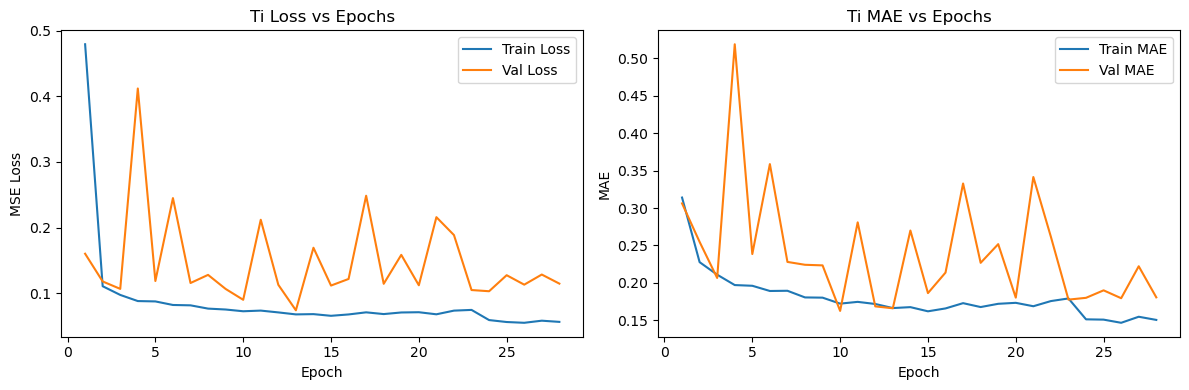

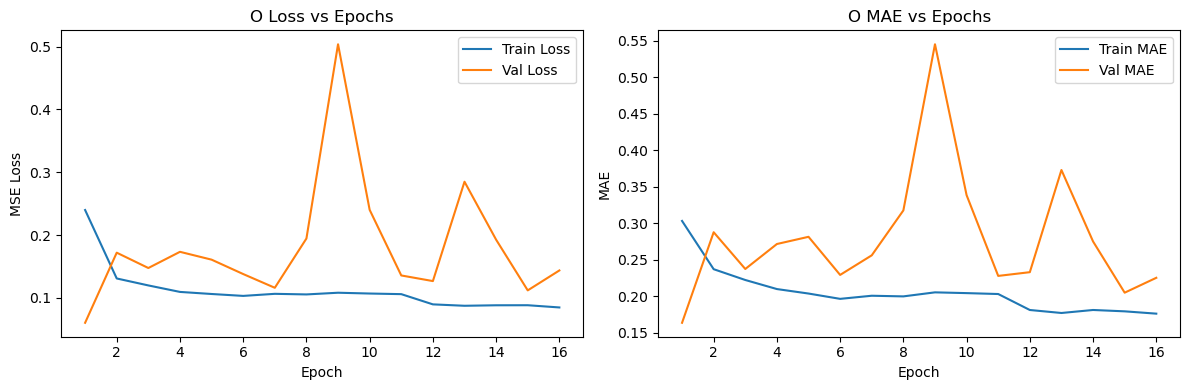


 Final Per-Structure Total Energy Metrics:
MAE  : 282.5012 eV
RMSE : 393.3549 eV
R²   : 0.9984


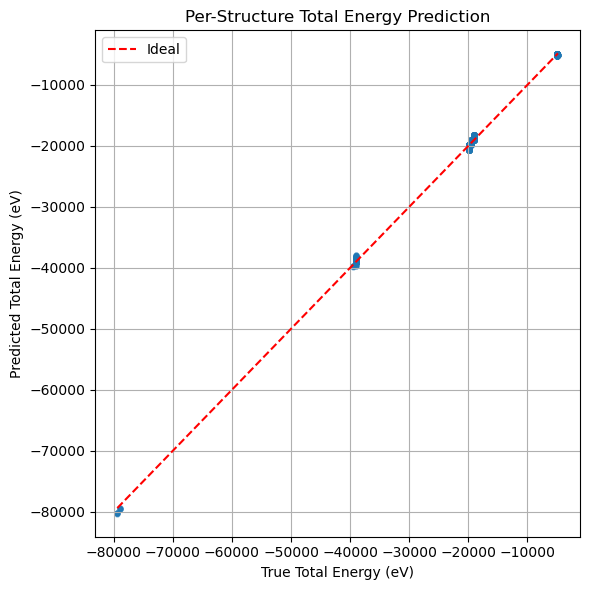

In [49]:
# Use species-specific top features from XGBoost analysis
ti_features = species_top_features['Ti']
o_features = species_top_features['O']

# === Species-Specific Data Preparation ===
def prepare_species_data(species, features):
    """Prepare scaled and split data for a specific species"""
    # Filter species data with structure-level split
    struct_ids = df[df['atom_type'] == species]['struct_id'].unique()
    train_structs, test_structs = train_test_split(struct_ids, test_size=0.2, random_state=42)
    
    train_mask = (df['struct_id'].isin(train_structs)) & (df['atom_type'] == species)
    test_mask = (df['struct_id'].isin(test_structs)) & (df['atom_type'] == species)

    # Feature scaling
    x_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(df[train_mask][features].values)
    X_test = x_scaler.transform(df[test_mask][features].values)
    
    # Target scaling
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(df[train_mask]['per_atom_energy'].values.reshape(-1, 1)).ravel()
    y_test = y_scaler.transform(df[test_mask]['per_atom_energy'].values.reshape(-1, 1)).ravel()
    
    return X_train, X_test, y_train, y_test, x_scaler, y_scaler, test_mask

# === Build Species-Specific Models ===
def build_species_model(input_dim):
    """Create optimized ANN architecture for atomic energy prediction"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(192, activation='tanh', kernel_regularizer=l2(0.0)),
        BatchNormalization(),
        Dropout(0.0),
        Dense(192, activation='tanh', kernel_regularizer=l2(0.0)),
        BatchNormalization(),
        Dropout(0.0),
        Dense(224, activation='tanh', kernel_regularizer=l2(0.0)),
        BatchNormalization(),
        Dropout(0.0),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0093313),
        loss='mse',
        metrics=['mae']
    )
    return model

# === Ti Model ===
print("\n=== Training Ti Model ===")
X_train_ti, X_test_ti, y_train_ti, y_test_ti, ti_x_scaler, ti_y_scaler, ti_test_mask = prepare_species_data('Ti', ti_features)
model_ti = build_species_model(len(ti_features))

history_ti = model_ti.fit(
    X_train_ti, y_train_ti,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=10)
    ],
    verbose=1
)

# === O Model ===
print("\n=== Training O Model ===")
X_train_o, X_test_o, y_train_o, y_test_o, o_x_scaler, o_y_scaler, o_test_mask = prepare_species_data('O', o_features)
model_o = build_species_model(len(o_features))

history_o = model_o.fit(
    X_train_o, y_train_o,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=10)
    ],
    verbose=1
)

# === Combined Evaluation ===
def inverse_scale(y, scaler):
    return scaler.inverse_transform(y.reshape(-1, 1)).ravel()

# Predict for both species
y_pred_ti = inverse_scale(model_ti.predict(X_test_ti), ti_y_scaler)
y_true_ti = inverse_scale(y_test_ti, ti_y_scaler)

y_pred_o = inverse_scale(model_o.predict(X_test_o), o_y_scaler)
y_true_o = inverse_scale(y_test_o, o_y_scaler)

# Combine results
combined_pred = np.concatenate([y_pred_ti, y_pred_o])
combined_true = np.concatenate([y_true_ti, y_true_o])

# Calculate metrics
print("\n Final Evaluation:")
print(f"Ti MAE: {mean_absolute_error(y_true_ti, y_pred_ti):.4f} eV/atom")
print(f"Ti RMSE: {np.sqrt(mean_squared_error(y_true_ti, y_pred_ti)):.4f} eV/atom")
print(f"O MAE: {mean_absolute_error(y_true_o, y_pred_o):.4f} eV/atom")
print(f"O RMSE: {np.sqrt(mean_squared_error(y_true_o, y_pred_o)):.4f} eV/atom")
print(f"Combined MAE: {mean_absolute_error(combined_true, combined_pred):.4f} eV/atom")
print(f"Combined RMSE: {np.sqrt(mean_squared_error(combined_true, combined_pred)):.4f} eV/atom")
print(f"Combined R²: {r2_score(combined_true, combined_pred):.4f}")

# === Visualization ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_true_ti, y_pred_ti, alpha=0.3, label='Ti')
plt.scatter(y_true_o, y_pred_o, alpha=0.3, label='O')
plt.plot([min(combined_true), max(combined_true)], [min(combined_true), max(combined_true)], 'k--')
plt.xlabel("True Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.title("Species-Specific Predictions")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(combined_true, combined_pred, alpha=0.3, c='purple')
plt.plot([min(combined_true), max(combined_true)], [min(combined_true), max(combined_true)], 'k--')
plt.xlabel("True Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.title("Combined Predictions")
plt.grid(True)

plt.tight_layout()
plt.savefig("species_combined_predictions_nn.png", dpi=300)
plt.show()


# === Plot Training Curves ===
def plot_training_curves(history, label=""):
    epochs = range(1, len(history.history["loss"]) + 1)
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    if "val_loss" in history.history:
        plt.plot(epochs, history.history["val_loss"], label="Val Loss")
    plt.title(f"{label} Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    if "mae" in history.history:
        plt.plot(epochs, history.history["mae"], label="Train MAE")
    if "val_mae" in history.history:
        plt.plot(epochs, history.history["val_mae"], label="Val MAE")
    plt.title(f"{label} MAE vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{label}_training_curves.png", dpi=300)
    plt.show()

plot_training_curves(history_ti, label="Ti")
plot_training_curves(history_o, label="O")


# === Reconstruct per-structure total energy predictions
structure_preds = defaultdict(list)
structure_true = {}

# Get predicted per-atom energies and original rows
all_preds = np.concatenate([y_pred_ti, y_pred_o])
df_test = df[ti_test_mask | o_test_mask].copy()
df_test["pred_per_atom_energy"] = all_preds

for _, row in df_test.iterrows():
    struct_id = row["struct_id"]
    structure_preds[struct_id].append(row["pred_per_atom_energy"])
    if struct_id not in structure_true:
        structure_true[struct_id] = row["total_energy"]

# === Build final structure-level arrays
y_true_struct = np.array([structure_true[k] for k in structure_preds])
y_pred_struct = np.array([sum(v) for v in structure_preds.values()])

# === Final per-structure metrics
struct_mae = mean_absolute_error(y_true_struct, y_pred_struct)
struct_rmse = mean_squared_error(y_true_struct, y_pred_struct, squared=False)
struct_r2 = r2_score(y_true_struct, y_pred_struct)

print("\n Final Per-Structure Total Energy Metrics:")
print(f"MAE  : {struct_mae:.4f} eV")
print(f"RMSE : {struct_rmse:.4f} eV")
print(f"R²   : {struct_r2:.4f}")

# === Per-Structure Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_struct, y_pred_struct, alpha=0.5, s=12)
plt.plot([min(y_true_struct), max(y_true_struct)],
         [min(y_true_struct), max(y_true_struct)],
         'r--', label="Ideal")
plt.xlabel("True Total Energy (eV)")
plt.ylabel("Predicted Total Energy (eV)")
plt.title("Per-Structure Total Energy Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("per_structure_total_energy_prediction_nn.png", dpi=300)
plt.show()



### Randomized Search (by atom)

In [ ]:

# # === Define model builder for Keras Tuner ===
# def model_builder(hp):
#     model = Sequential()
#     model.add(Input(shape=(10,)))  # Adjust based on number of features

#     for i in range(hp.Int("num_layers", 2, 3)):
#         units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
#         model.add(Dense(units, activation='tanh', kernel_regularizer=l2(hp.Choice("l2", [0.0, 0.001]))))
#         model.add(BatchNormalization())
#         model.add(Dropout(hp.Float("dropout", 0.0, 0.3, step=0.05)))

#     model.add(Dense(1))
#     model.compile(
#         optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling='log')),
#         loss="mse"
#     )
#     return model

# # === Optimization function per species ===
# def optimize_species(species, features):
#     print(f"\n🔧 Tuning model for {species}")

#     struct_ids = df[df["atom_type"] == species]["struct_id"].unique()
#     train_structs, test_structs = train_test_split(struct_ids, test_size=0.2, random_state=42)
#     train_mask = df["struct_id"].isin(train_structs) & (df["atom_type"] == species)
#     test_mask = df["struct_id"].isin(test_structs) & (df["atom_type"] == species)

#     X_train = df.loc[train_mask, features].values
#     y_train = df.loc[train_mask, "per_atom_energy"].values
#     X_test = df.loc[test_mask, features].values
#     y_test = df.loc[test_mask, "per_atom_energy"].values

#     x_scaler = StandardScaler().fit(X_train)
#     y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

#     X_train_scaled = x_scaler.transform(X_train)
#     y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
#     X_test_scaled = x_scaler.transform(X_test)
#     y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

#     tuner = kt.RandomSearch(
#         model_builder,
#         objective="val_loss",
#         max_trials=25,
#         executions_per_trial=1,
#         directory="kt_tuning",
#         project_name=f"mlp_{species}",
#         overwrite=True
#     )

#     tuner.search(
#         X_train_scaled, y_train_scaled,
#         validation_split=0.1,
#         epochs=20,
#         batch_size=256,
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
#             tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
#         ],
#         verbose=1
#     )

#     best_model = tuner.get_best_models(1)[0]
#     best_hp = tuner.get_best_hyperparameters(1)[0]

#     # Evaluate
#     y_pred_scaled = best_model.predict(X_test_scaled).ravel()
#     y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
#     y_true = y_test

#     return y_true, y_pred, best_model, best_hp

# # === Run tuning for both species
# results = {}
# for species, features in species_top_features.items():
#     y_true, y_pred, model, best_hp = optimize_species(species, features)
#     results[species] = {
#         "y_true": y_true,
#         "y_pred": y_pred,
#         "best_hp": best_hp
#     }

# # === Combined Evaluation
# all_true = np.concatenate([results[s]["y_true"] for s in results])
# all_pred = np.concatenate([results[s]["y_pred"] for s in results])

# print("\nFinal Evaluation:")
# for s in results:
#     mae = mean_absolute_error(results[s]["y_true"], results[s]["y_pred"])
#     print(f"{s} MAE: {mae:.4f} eV/atom")
#     print(f"   Best HP: {results[s]['best_hp'].values}")
# combined_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
# print(f"Combined MAE: {mean_absolute_error(all_true, all_pred):.4f}")
# print(f"Combined RMSE: {combined_rmse:.4f} eV/atom")
# print(f"Combined R² : {r2_score(all_true, all_pred):.4f}")

# # === Plot
# plt.figure(figsize=(6, 6))
# plt.scatter(all_true, all_pred, alpha=0.4, s=10)
# plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--')
# plt.xlabel("True per-atom energy (eV)")
# plt.ylabel("Predicted per-atom energy (eV)")
# plt.title("MLP with Keras Tuner")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Trial 1 Complete [00h 14m 52s]
val_loss: 0.11337384581565857

Best val_loss So Far: 0.11337384581565857
Total elapsed time: 00h 14m 52s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
2                 |3                 |num_layers
128               |224               |units_0
0.001             |0.001             |l2
0.05              |0.15              |dropout
128               |64                |units_1
0.00035556        |0.00066058        |lr
224               |32                |units_2

Epoch 1/30
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.5411 - val_loss: 0.2455 - learning_rate: 3.5556e-04
Epoch 2/30
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.3214 - val_loss: 0.2251 - learning_rate: 3.5556e-04
Epoch 3/30
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - loss: 0.2502 - val_loss: 0.1973 - learning_rate: 3.5556e-04
Epoch 4/30
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.2067 - val_loss: 0.1673 - learning_rate: 3.5556e

KeyboardInterrupt: 

Did not have time to follow through with this.